In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [22]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

First generate stuff for the whole team

In [3]:
team_stats_df = aps.generate_full_team_aggregate( 2017 )

Next, generate kicker statistics

In [4]:
n_weeks = 4

all_kicker_data = pd.DataFrame()

# Get all the team preseason data
# Can id by team, week, year
for year in range( 2009, 2017 ):
    new_frame = gps.generate_stats( 'K', year, season_type='Preseason' )
    new_frame['year'] = year
    all_kicker_data = pd.concat( [all_kicker_data, new_frame], ignore_index=True )

all_kicker_data['week'] = all_kicker_data['week']-4
    
# Get all the Kicker regular season data
# Can id by team, week, year
for year in range( 2009, 2017 ):
    new_frame = gps.generate_stats( 'K', year )
    new_frame['year'] = year
    all_kicker_data = pd.concat( [all_kicker_data, new_frame], ignore_index=True )
    
# Ignore some team stuff, can get from joining with team
all_kicker_data = all_kicker_data.drop( ['opp_team','home_flag','away_flag','xp_made','xp_miss'],axis=1 )

# Generate previous rolling sum
prev_kick = aps.calc_prev_player_stats( all_kicker_data, ['fg_made','fg_miss','fg_made_yds','fg_miss_yds','fg_made_max'] )

# Combine present values with rolling sums
all_kicker_data = pd.merge( all_kicker_data, prev_kick, on=['player_id','team','year','week'] )

# Drop all the preseason stuff
all_kicker_data = all_kicker_data.loc[ all_kicker_data['week']>0 ]

# Note if the data includes preseason stuff
# If the first four games, flag as preseason data included
# This is tricky, as can have a bye-week
# Therefore, group things, find the first n_weeks, and flag those as 1
inds = all_kicker_data.groupby(['player_id','year'], as_index=False).nth( range(0, n_weeks) ).index.values

all_kicker_data    [       'few_reg_weeks'] = 0
all_kicker_data.loc[ inds, 'few_reg_weeks'] = 1

In [5]:
all_kicker_data.head(20)

,player_id,team,week,fg_made,fg_miss,fg_made_yds,fg_miss_yds,fg_made_max,fg_miss_min,year,fg_made_prev_4,fg_miss_prev_4,fg_made_yds_prev_4,fg_miss_yds_prev_4,fg_made_max_prev_4,few_reg_weeks
688,00-0004091,CLE,1,2,0,57,0,37,NaN,2009,8.0,1.0,259.0,41.0,121.0,1
689,00-0004091,CLE,2,2,0,69,0,47,NaN,2009,10.0,0.0,316.0,0.0,158.0,1
690,00-0004091,CLE,8,0,0,0,0,0,NaN,2009,10.0,0.0,318.0,0.0,171.0,1
691,00-0004091,CLE,10,0,0,0,0,0,NaN,2009,7.0,0.0,229.0,0.0,134.0,1
692,00-0004091,CLE,11,2,0,73,0,44,NaN,2009,4.0,0.0,126.0,0.0,84.0,0
693,00-0004091,CLE,12,0,0,0,0,0,NaN,2009,4.0,0.0,142.0,0.0,91.0,0
694,00-0004091,CLE,13,1,1,49,43,49,43.0,2009,2.0,0.0,73.0,0.0,44.0,0
695,00-0004091,CLE,14,2,0,58,0,29,NaN,2009,3.0,1.0,122.0,43.0,93.0,0
696,00-0004091,CLE,15,2,1,77,52,47,52.0,2009,5.0,1.0,180.0,43.0,122.0,0
697,00-0004091,CLE,16,3,0,109,0,42,NaN,2009,5.0,2.0,184.0,95.0,125.0,0


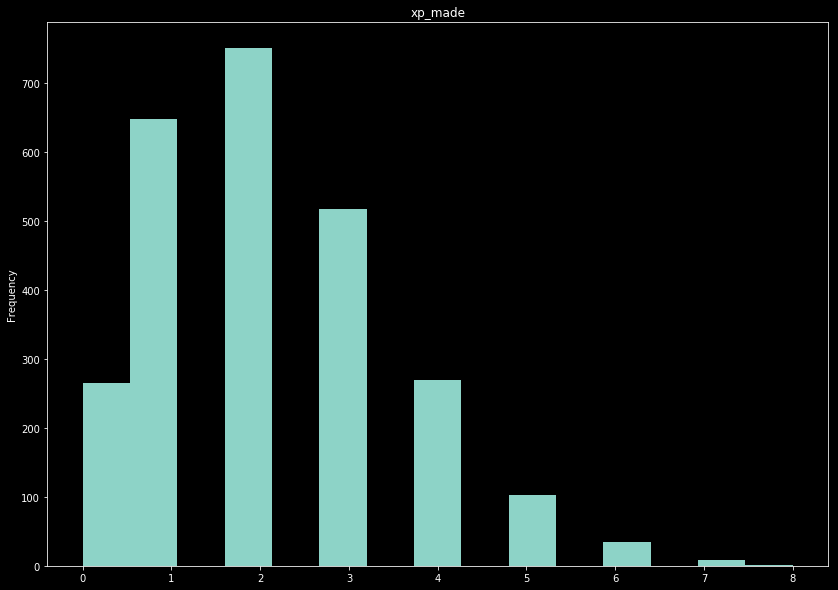

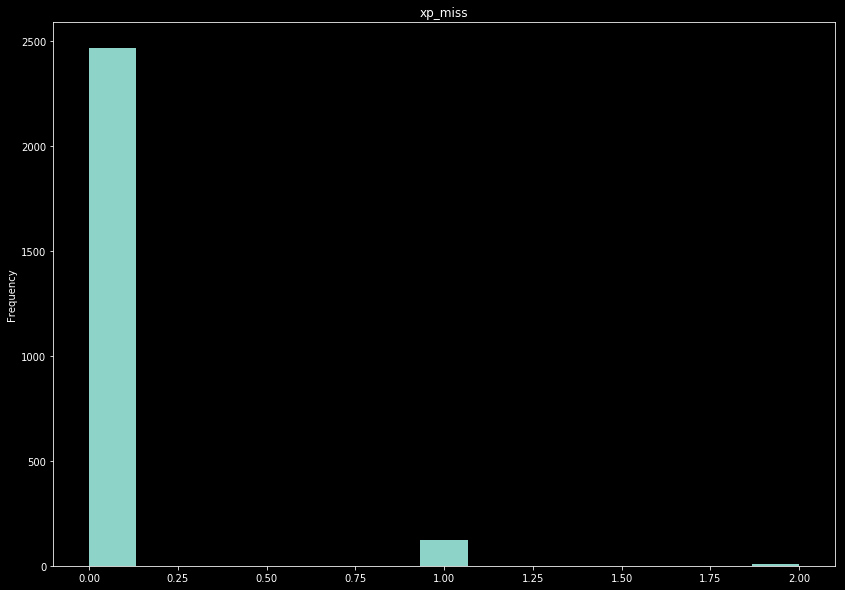

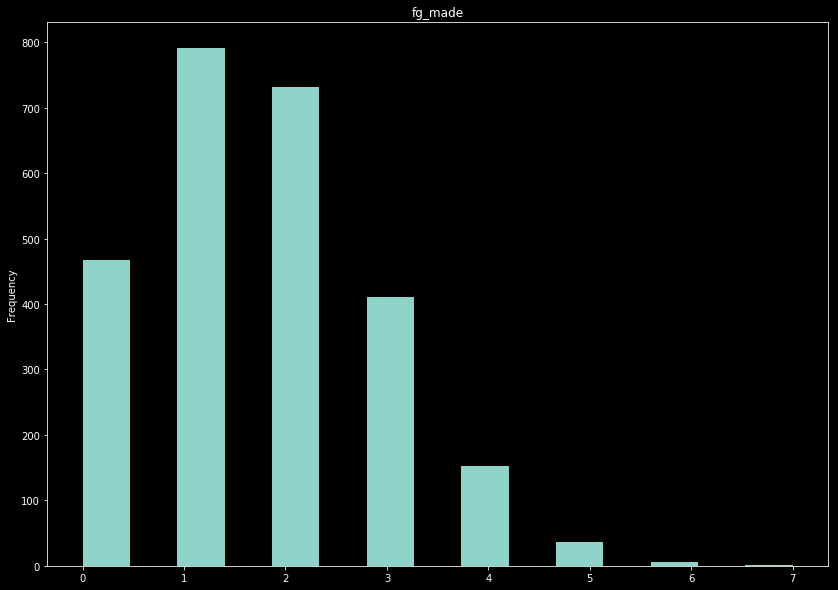

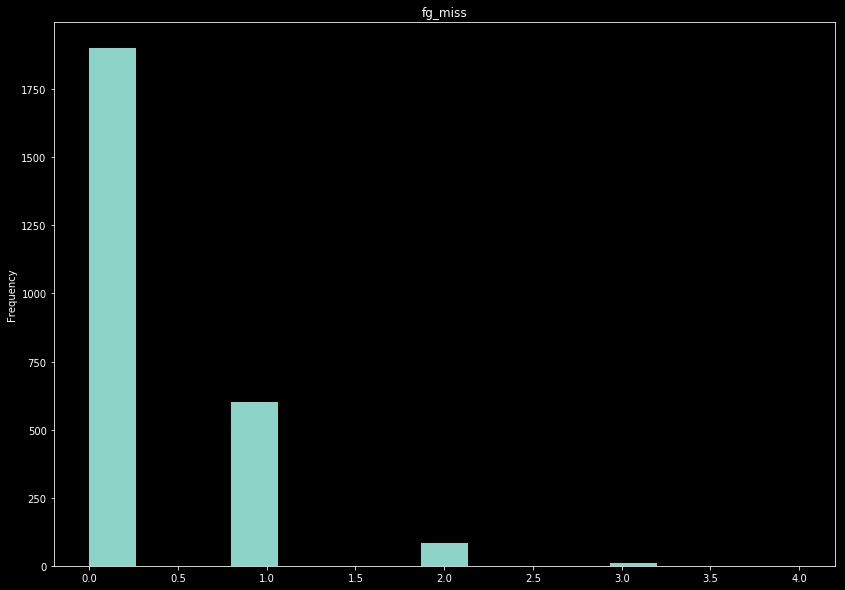

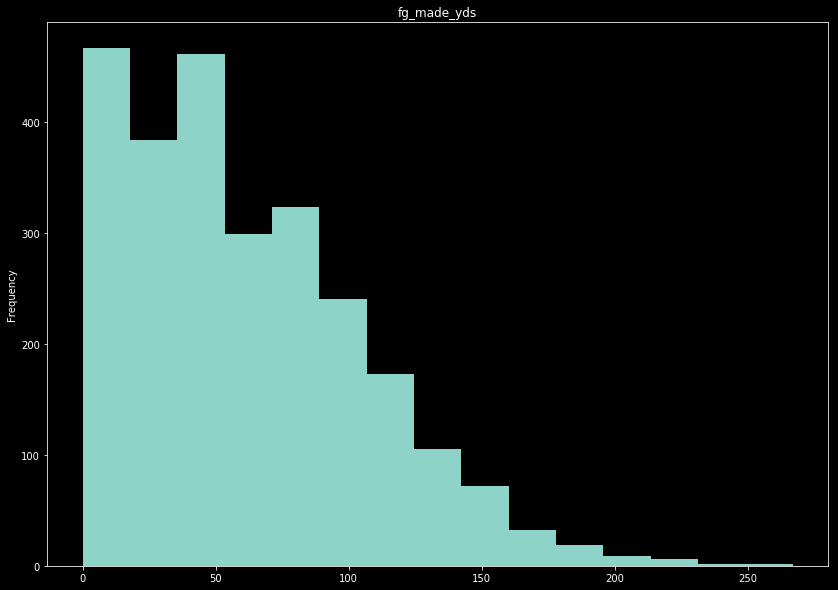

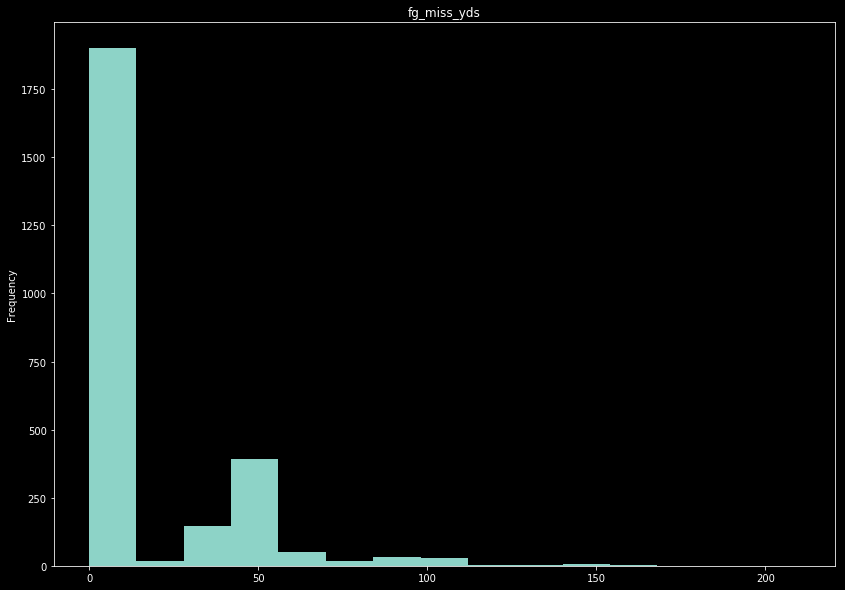

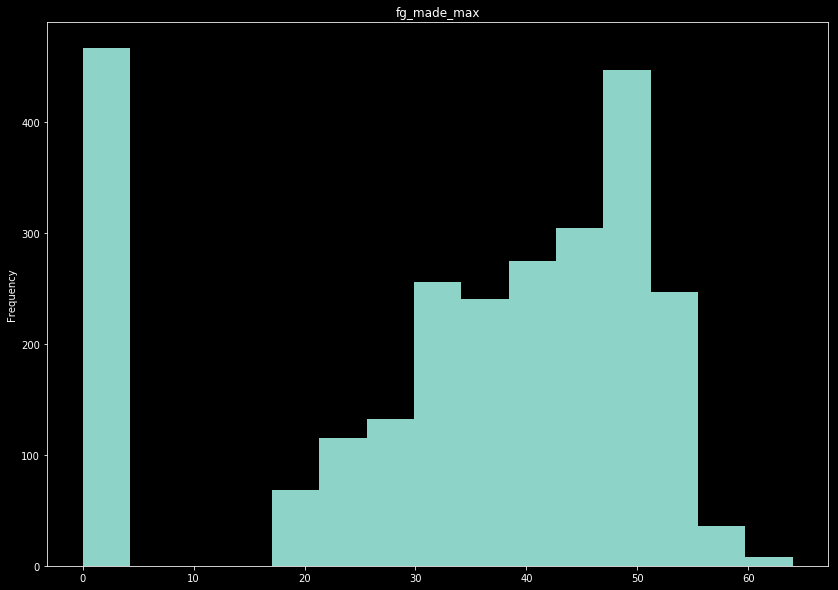

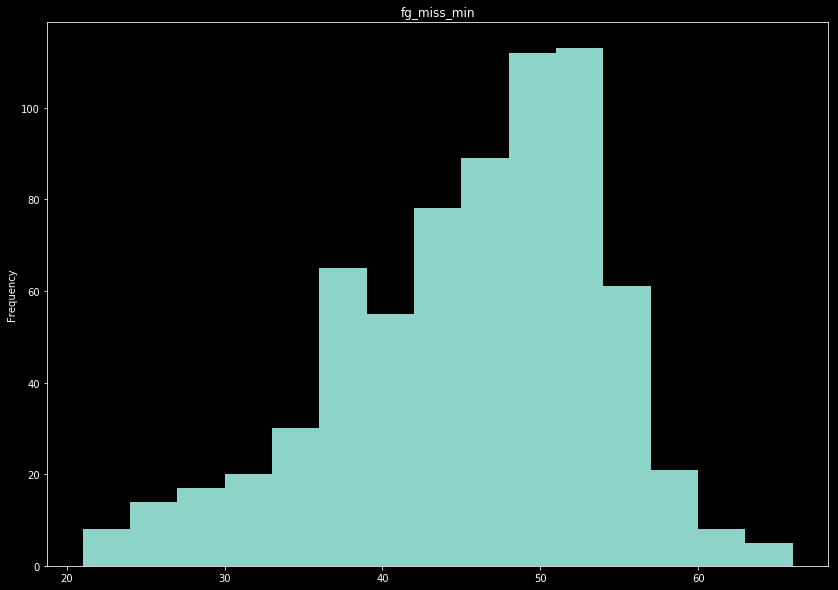

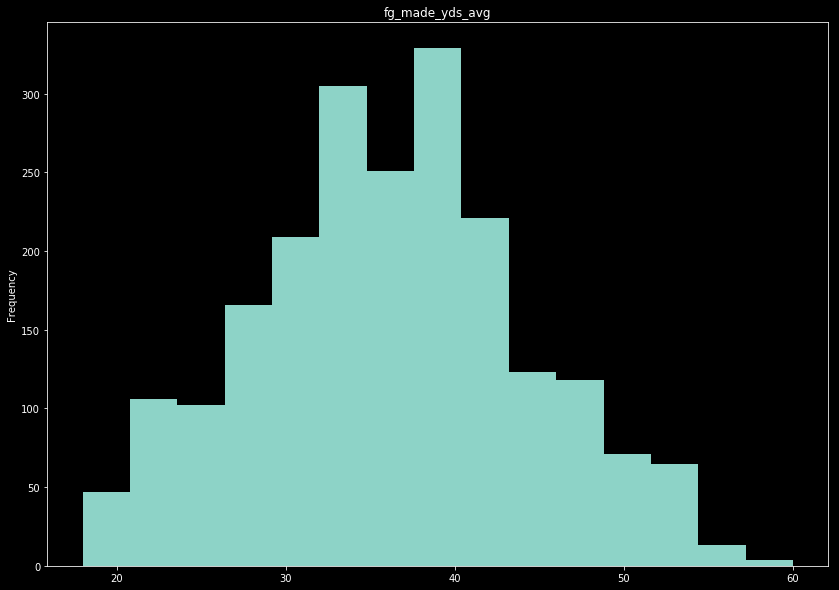

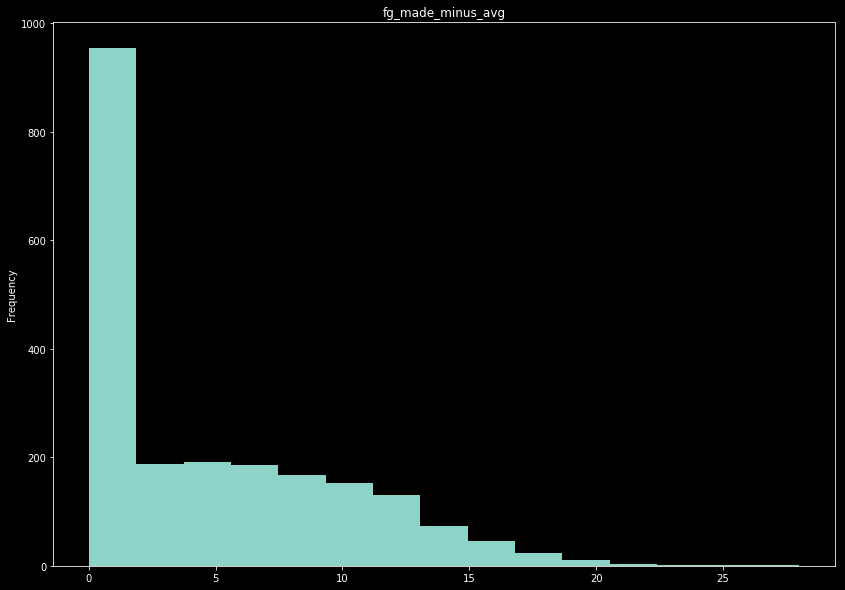

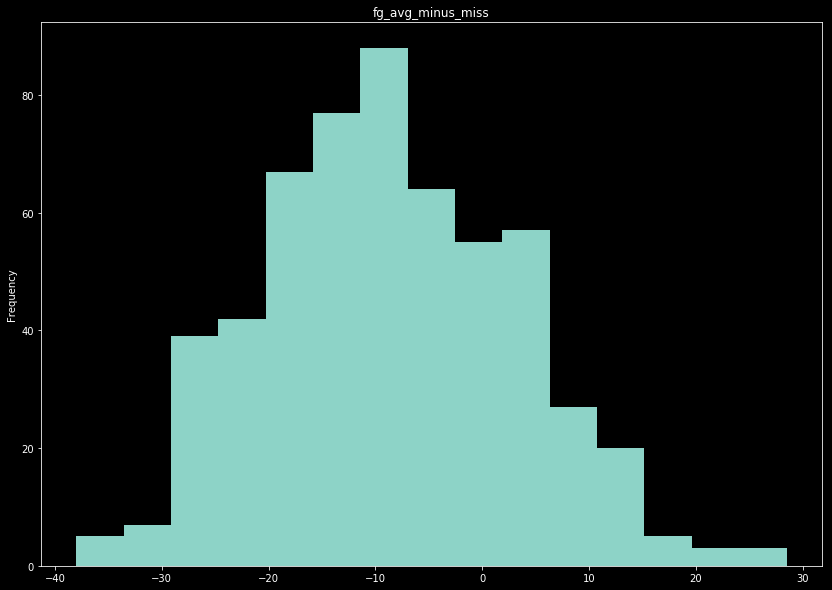

In [19]:
foo = all_kicker_data.drop(['player_id','team','week','year'],axis=1).copy()

foo['fg_made_yds_avg'  ] = foo['fg_made_yds'    ] / foo['fg_made']
foo['fg_made_minus_avg'] = foo['fg_made_max'    ] - foo['fg_made_yds_avg']
foo['fg_avg_minus_miss'] = foo['fg_made_yds_avg'] - foo['fg_miss_min']

for col in foo.columns.values:
    foo[col].plot.hist( bins=15, title=col )
    plt.show()

5 pts per 50+ yard FG made

4 pts per 40-49 yard FG made

3 pts per FG made, 39 yards or less

2 pts per rushing, passing, or receiving 2 pt conversion

1 pt per Extra Point made

Penalty Points

-2 pts per missed FG (0-39 yds)

-1 pt per missed FG (40-49 yds)

(note: a missed FG includes any attempt that is blocked, deflected, etc.)

In [6]:
print all_kicker_data.loc[all_kicker_data['xp_made']>0]['xp_made'].sum()
print all_kicker_data.loc[all_kicker_data['xp_miss']>0]['xp_miss'].sum()

5564
138


Ignore xp stuff, it's easy enough to get. Just predict from team's touchdowns

In [7]:
print all_kicker_data.loc[all_kicker_data['fg_made_max']>=50].shape
print all_kicker_data.loc[all_kicker_data['fg_made_max']< 50].shape

(443, 13)
(2154, 13)


In [14]:
print all_kicker_data.loc[all_kicker_data['fg_miss_min'].isnull()].shape
print all_kicker_data.loc[all_kicker_data['fg_miss_min'].notnull()].shape

(1901, 12)
(696, 12)


Should handle carfully. 

Consider timeframes to store min/max?

Measure relative to avg yardage?

In [6]:
team_stats_df.columns.values

array([u'team', 'opp_team', u'week', 'year', 'score', 'opp_score',
       'home_flag', 'away_flag', 'tds', u'rush_att', u'rush_yds',
       u'pass_att', u'pass_yds', u'pass_cmp', u'pass_sack', u'kickoffs',
       u'punts', u'fg_miss', u'off_fumb_tot', u'kickoff_in_20',
       u'kickoff_touchback', u'fg_yds', u'fg_made', u'def_int_tds',
       u'def_frec_tds', u'def_misc_tds', u'def_safety', u'def_tkl',
       u'def_tkl_contributers', u'def_fumb_forced', u'def_int',
       u'def_tkl_loss', u'def_sack', u'def_pass_def', 'score_prev_4',
       'opp_score_prev_4', 'home_flag_prev_4', 'away_flag_prev_4',
       'tds_prev_4', 'rush_att_prev_4', 'rush_yds_prev_4',
       'pass_att_prev_4', 'pass_yds_prev_4', 'pass_cmp_prev_4',
       'pass_sack_prev_4', 'kickoffs_prev_4', 'punts_prev_4',
       'fg_miss_prev_4', 'off_fumb_tot_prev_4', 'kickoff_in_20_prev_4',
       'kickoff_touchback_prev_4', 'fg_yds_prev_4', 'fg_made_prev_4',
       'def_int_tds_prev_4', 'def_frec_tds_prev_4', 'def_misc_tds_

In [6]:
team_stuff = [
                'tds',
                'punts',
                'kickoff_in_20', 
                'kickoff_touchback',
                'fg_yds',
                'fg_made',
                'fg_miss',
                'score_prev_4',
                'opp_score_prev_4', 
                'tds_prev_4',  
                'kickoffs_prev_4', 
                'punts_prev_4',
                'fg_miss_prev_4', 
                'kickoff_in_20_prev_4',
                'kickoff_touchback_prev_4', 
                'fg_yds_prev_4', 
                'fg_made_prev_4',
                'includes_preseason'
            ]

team_kick = team_stats_df[team_stuff].copy()
team_kick.columns = [ 'team_'+x for x in team_kick.columns.values ]
team_kick['team'] = team_stats_df['team'].copy()
team_kick['week'] = team_stats_df['week'].copy()
team_kick['year'] = team_stats_df['year'].copy()

In [7]:
team_kick.head()

,team_tds,team_punts,team_kickoff_in_20,team_kickoff_touchback,team_fg_yds,team_fg_made,team_fg_miss,team_score_prev_4,team_opp_score_prev_4,team_tds_prev_4,...,team_punts_prev_4,team_fg_miss_prev_4,team_kickoff_in_20_prev_4,team_kickoff_touchback_prev_4,team_fg_yds_prev_4,team_fg_made_prev_4,team_includes_preseason,team,week,year
1036,1,6,1,2,116,3,0,53.0,100.0,6.0,...,17.0,0.0,2.0,2.0,126.0,4.0,1,ARI,1,2009
1037,4,3,1,2,45,1,1,59.0,100.0,6.0,...,17.0,0.0,3.0,3.0,213.0,6.0,1,ARI,2,2009
1038,1,6,0,2,38,1,0,84.0,100.0,10.0,...,17.0,1.0,2.0,5.0,190.0,5.0,1,ARI,3,2009
1039,4,7,0,1,0,0,0,57.0,87.0,6.0,...,22.0,1.0,2.0,6.0,199.0,5.0,1,ARI,5,2009
1040,3,6,1,2,60,2,0,85.0,89.0,10.0,...,22.0,1.0,2.0,7.0,199.0,5.0,0,ARI,6,2009


In [8]:
k_team_comb = pd.merge( all_kicker_data, team_kick, on=['team','week','year'] )

In [19]:
cols = k_team_comb.columns.values[3:]

counter = 0
for col in cols:
    print col
    foo = k_team_comb[cols].corrwith( k_team_comb[col] ).sort_values()
    print abs(foo).sum()
    print foo
    print ' '
    counter = counter + 1
    if counter == 13:
        break

fg_made
5.99574335979
team_punts                      -0.253351
team_tds                        -0.205458
team_fg_miss                    -0.052887
fg_miss_yds                     -0.051971
fg_miss                         -0.051946
team_punts_prev_4               -0.046403
fg_miss_yds_prev_4              -0.027179
fg_miss_prev_4                  -0.024373
team_fg_miss_prev_4             -0.016441
team_opp_score_prev_4           -0.012127
fg_miss_min                     -0.002569
fg_made_max_prev_4               0.005346
team_fg_made_prev_4              0.007585
team_includes_preseason          0.009029
team_fg_yds_prev_4               0.011898
fg_made_prev_4                   0.015592
team_kickoffs_prev_4             0.016881
few_reg_weeks                    0.016939
fg_made_yds_prev_4               0.017918
team_tds_prev_4                  0.019760
team_score_prev_4                0.021120
year                             0.021230
team_kickoff_in_20_prev_4        0.023521
team_kickoff

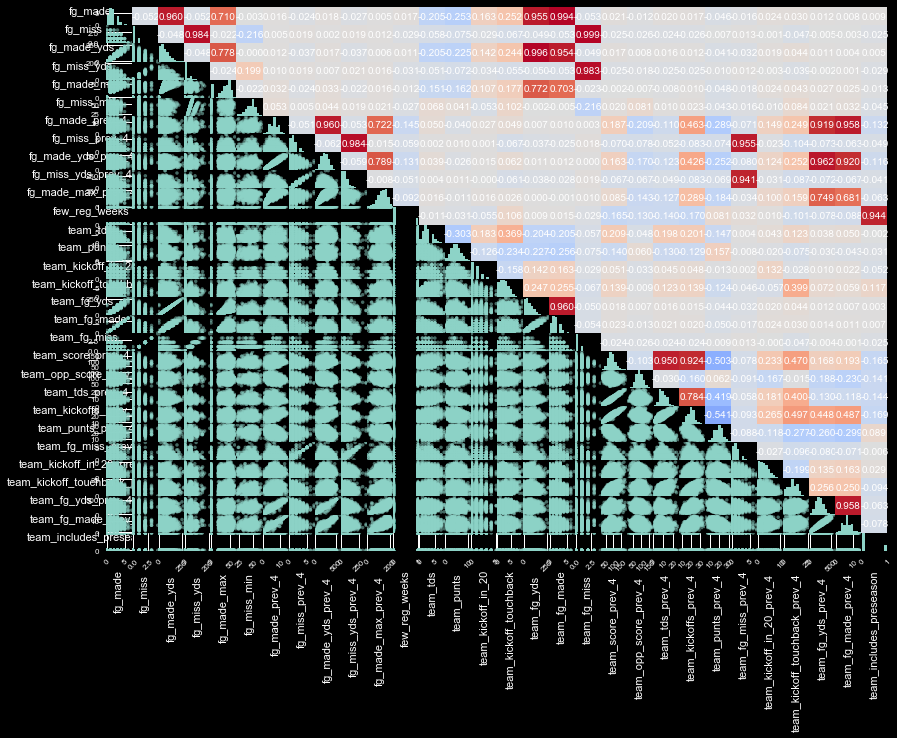

In [27]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( k_team_comb[cols].drop('year',axis=1), y_label_rotation=0, x_label_rotation=90 )

In [28]:
# FG made most dependent on fg_made_yds, fg_made_max, team_fg_made, team_fg_yds
# FG miss min completely uncorrelated
#  as is team_tds, team_punts, team_kickoff_in_20, team_kickoff_touchback
# Prob can drop team_kickoffs_prev_4, team_punts_prev_4, team_fg_miss_prev_4, team_kickoff_in_20_prev_4
#  team_kickoff_touchback_prev_4, team_includes_preseason

In [29]:
k_team_comb = k_team_comb.drop(
                                [
                                    'fg_miss_min',
                                    'fg_miss',
                                    'fg_made_yds',
                                    'fg_miss_yds',
                                    'team_tds',
                                    'team_punts',
                                    'team_kickoff_in_20',
                                    'team_kickoff_touchback',
                                    'team_kickoffs_prev_4',
                                    'team_punts_prev_4',
                                    'team_fg_miss_prev_4',
                                    'team_fg_yds_prev_4',
                                    'team_fg_yds',
                                    'team_fg_made',
                                    'team_fg_miss',
                                    'team_kickoff_in_20_prev_4',
                                    'team_opp_score_prev_4',
                                    'team_kickoff_touchback_prev_4'
                                ], axis=1 )

In [47]:
k_team_comb = k_team_comb.drop(['fg_miss','fg_made_yds','fg_miss_yds'],axis=1)

In [49]:
k_team_comb.columns.values

array([u'player_id', u'team', u'week', u'fg_made', u'fg_made_max', 'year',
       'fg_made_prev_4', 'fg_miss_prev_4', 'fg_made_yds_prev_4',
       'fg_miss_yds_prev_4', 'fg_made_max_prev_4', 'few_reg_weeks',
       'team_score_prev_4', 'team_tds_prev_4', 'team_fg_yds_prev_4',
       'team_fg_made_prev_4', 'team_includes_preseason'], dtype=object)

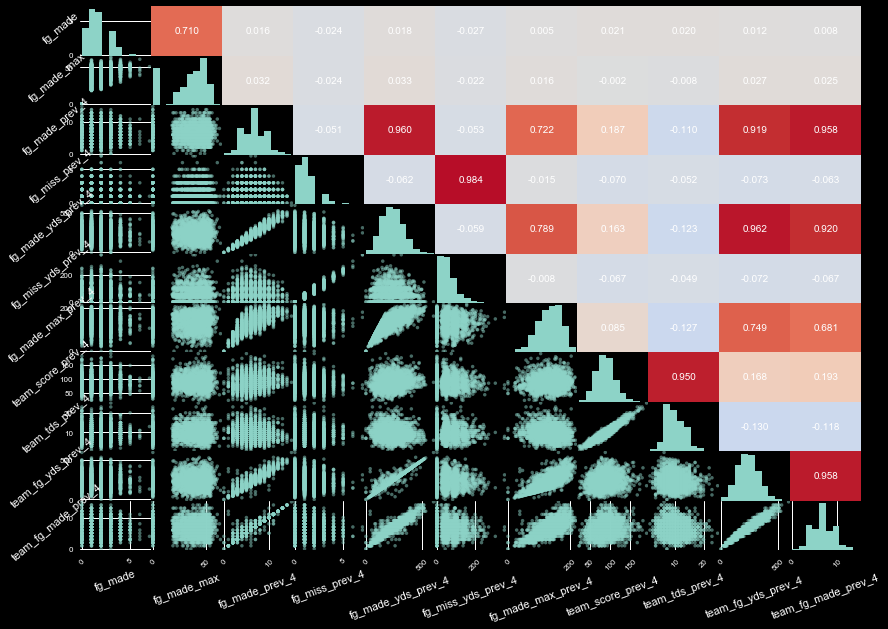

In [48]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( k_team_comb.drop( ['year','week','team_includes_preseason','few_reg_weeks'],axis=1), 
             y_label_rotation=40, x_label_rotation=20 )

In [66]:
max_group_k.columns.values

array([u'player_id', u'team', u'week', u'fg_made', u'fg_made_max', 'year',
       'fg_made_prev_4', 'fg_miss_prev_4', 'fg_made_yds_prev_4',
       'fg_miss_yds_prev_4', 'fg_made_max_prev_4', 'few_reg_weeks',
       'team_score_prev_4', 'team_tds_prev_4', 'team_fg_yds_prev_4',
       'team_fg_made_prev_4', 'team_includes_preseason'], dtype=object)

In [79]:
test_features = k_team_comb[['player_id','team','year','week']].copy()

n_weeks = 4

test_features['fg_made'       ] = k_team_comb['fg_made'].copy()
test_features['fg_made_prev_4'] = k_team_comb['fg_made_prev_4'] / n_weeks
test_features['fg_acc_prev_4' ] = k_team_comb['fg_made_prev_4'] / ( k_team_comb['fg_made_prev_4'] + k_team_comb['fg_miss_prev_4'] )


test_features['fg_made_yds_prev_4_avg'] = k_team_comb['fg_made_yds_prev_4'] / k_team_comb['fg_made_prev_4']
test_features['fg_miss_yds_prev_4_avg'] = k_team_comb['fg_miss_yds_prev_4'] / k_team_comb['fg_miss_prev_4']


max_group_k = k_team_comb.groupby(['player_id','year'],as_index=False).rolling(100,min_periods=1).max()
max_group_k['week'] = max_group_k['week'].astype(int)
max_group_k['fg_max'] = max_group_k['fg_made_max']
test_features['fg_max_season'] = pd.merge( k_team_comb, max_group_k, on=['player_id','year','week'] )['fg_max']
max_group_k = 0


test_features['fg_max_avg'  ] = test_features['fg_max_season'         ] - test_features['fg_made_yds_prev_4_avg']
test_features['fg_made_miss'] = test_features['fg_made_yds_prev_4_avg'] - test_features['fg_miss_yds_prev_4_avg']

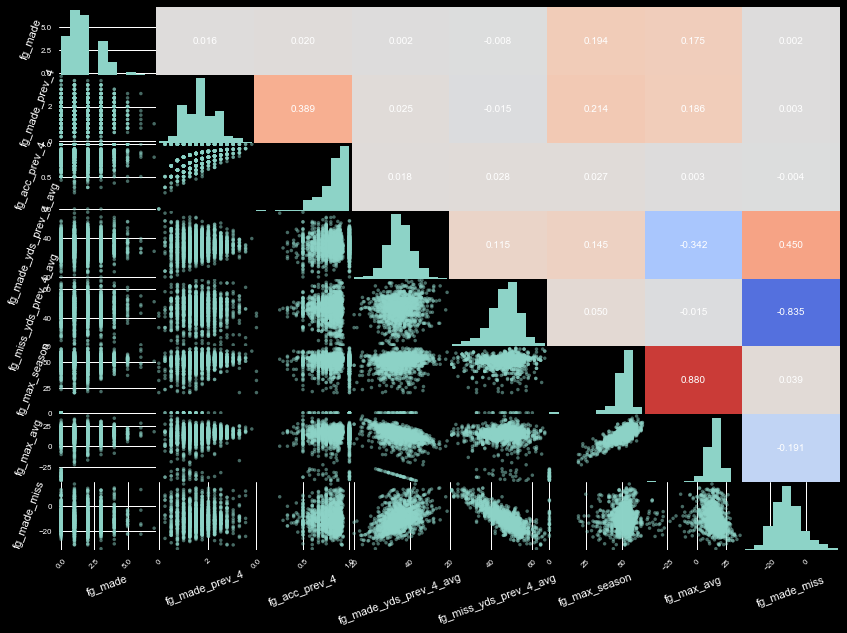

In [81]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( test_features.drop(['year','week'], axis=1), 
             y_label_rotation=70, x_label_rotation=20 )

5 pts per 50+ yard FG made

4 pts per 40-49 yard FG made

3 pts per FG made, 39 yards or less

2 pts per rushing, passing, or receiving 2 pt conversion

1 pt per Extra Point made

Penalty Points

-2 pts per missed FG (0-39 yds)

-1 pt per missed FG (40-49 yds)

(note: a missed FG includes any attempt that is blocked, deflected, etc.)

In [84]:
reload(aps)
foo = aps.generate_kicker_features( 2017 )

In [85]:
foo.head()

,player_id,team,year,week,few_reg_weeks,fg_made,fg_made_prev_4_avg,fg_acc_prev_4,fg_made_yds_prev_4_avg,fg_miss_yds_prev_4_avg,fg_max_season,fg_max_avg,fg_made_miss
688,00-0004091,CLE,2009,1,1,2,2.00,0.888889,32.375000,41.0,52.0,19.625000,-8.625
689,00-0004091,CLE,2009,2,1,2,2.50,1.000000,31.600000,NaN,52.0,20.400000,NaN
690,00-0004091,CLE,2009,8,1,0,2.50,1.000000,31.800000,NaN,52.0,20.200000,NaN
691,00-0004091,CLE,2009,10,1,0,1.75,1.000000,32.714286,NaN,52.0,19.285714,NaN
692,00-0004091,CLE,2009,11,0,2,1.00,1.000000,31.500000,NaN,52.0,20.500000,NaN


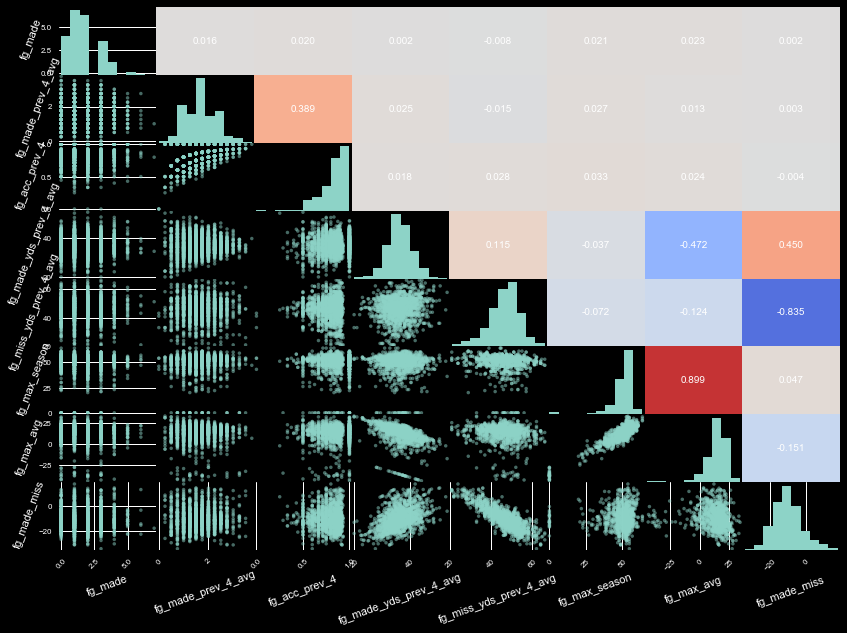

In [86]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( foo.drop(['year','week','few_reg_weeks'], axis=1), 
             y_label_rotation=70, x_label_rotation=20 )